In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

# File paths
dga_malware_file = "/home/ubuntu/DoH_DGA_training/datasets/DGA/all_pcaps_allN.csv"
dga_synthetic_file = "/home/ubuntu/DoH_DGA_training/datasets/DGA_PCAPS1_ENC/all_pcaps_allN.csv"
doh_tunnel_file = "/home/ubuntu/DoH_DGA_training/datasets/DoH_HKD/DoH-Pcaps/all_pcaps_allN.csv"

# Load datasets
df_dga_malware = pd.read_csv(dga_malware_file)
df_dga_synthetic = pd.read_csv(dga_synthetic_file)
df_doh_tunnel = pd.read_csv(doh_tunnel_file)

# Assign labels
df_dga_malware["label"] = "DGA_MALWARE"
df_dga_synthetic["label"] = "DGA_Synthetic"
df_doh_tunnel["label"] = "DoH_Tunnel"

print("DGA_MALWARE shape:", df_dga_malware.shape)
print("DGA_Synthetic shape:", df_dga_synthetic.shape)
print("DoH_Tunnel shape:", df_doh_tunnel.shape)

# Combine all into one DataFrame
df_all = pd.concat([df_dga_malware, df_dga_synthetic, df_doh_tunnel], ignore_index=True)

print("\nFinal dataset shape:", df_all.shape)
print("Labels distribution:\n", df_all["label"].value_counts())
print("Columns:\n", list(df_all.columns))


DGA_MALWARE shape: (9012, 25)
DGA_Synthetic shape: (2628, 25)
DoH_Tunnel shape: (6008, 26)

Final dataset shape: (17648, 26)
Labels distribution:
 label
DGA_MALWARE      9012
DoH_Tunnel       6008
DGA_Synthetic    2628
Name: count, dtype: int64
Columns:
 ['session_id', 'client_ip', 'server_ip', 'client_port', 'server_port', 'protocol', 'N', 'n_client', 'client_bytes', 'client_pkt_min', 'client_pkt_mean', 'client_pkt_max', 'client_iat_min', 'client_iat_mean', 'client_iat_max', 'n_server', 'server_bytes', 'server_pkt_min', 'server_pkt_mean', 'server_pkt_max', 'server_iat_min', 'server_iat_mean', 'server_iat_max', 'bytes_ratio', 'label', 'pcap_file']


In [31]:
N_value = 32   # <-- change this to 8, 16, 32, 64 as needed
df_subset = df_all[df_all["N"] == N_value].copy()

print(f"\nTraining on N={N_value}, dataset size={df_subset.shape[0]}")

# Separate features and target
y = df_subset["label"]
X = df_subset.drop(columns=[
    "label", 'session_id', 'client_ip', 'server_ip', 
    'client_port', 'server_port', 'protocol', 'N',
    "flow_id", "src_ip", "dst_ip", 
    "src_port", "dst_port", "protocol", 'pcap_file'
], errors="ignore")

# Keep only numeric features
X = X.select_dtypes(include=["int64", "float64"])

print("Remaining feature columns:\n", list(X.columns))
print("Target classes:", y.unique())


Training on N=32, dataset size=4412
Remaining feature columns:
 ['n_client', 'client_bytes', 'client_pkt_min', 'client_pkt_mean', 'client_pkt_max', 'client_iat_min', 'client_iat_mean', 'client_iat_max', 'n_server', 'server_bytes', 'server_pkt_min', 'server_pkt_mean', 'server_pkt_max', 'server_iat_min', 'server_iat_mean', 'server_iat_max', 'bytes_ratio']
Target classes: ['DGA_MALWARE' 'DGA_Synthetic' 'DoH_Tunnel']


In [32]:
# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [33]:
# Train MLP
mlp = MLPClassifier(hidden_layer_sizes=(16,8,4), max_iter=200, random_state=42)
mlp.fit(X_train, y_train)

# Evaluate
y_pred = mlp.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Classification Report:
               precision    recall  f1-score   support

  DGA_MALWARE       1.00      1.00      1.00       451
DGA_Synthetic       0.99      1.00      1.00       131
   DoH_Tunnel       1.00      1.00      1.00       301

     accuracy                           1.00       883
    macro avg       1.00      1.00      1.00       883
 weighted avg       1.00      1.00      1.00       883



/home/ubuntu/miniconda/envs/jupyterenv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


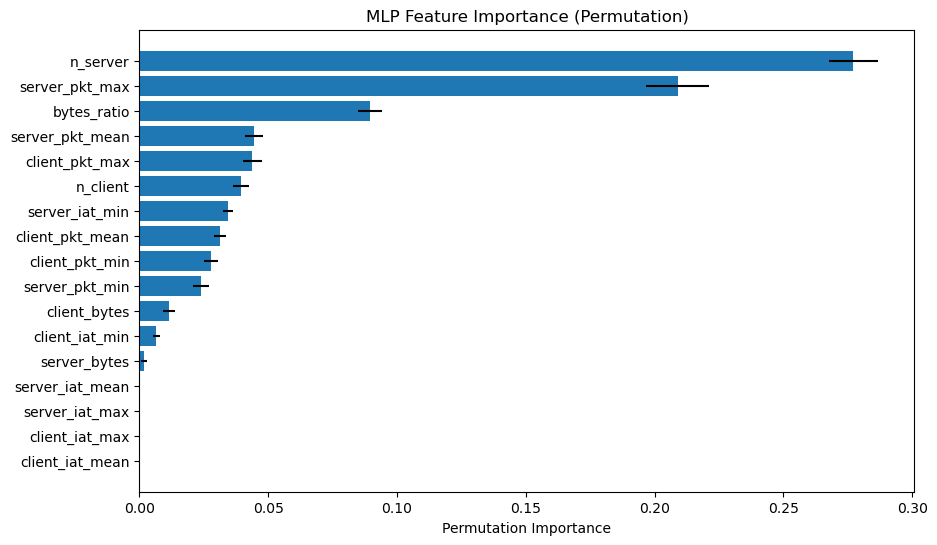

In [34]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# Compute permutation importance on test set
result = permutation_importance(
    mlp, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

# Sort by importance
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], xerr=result.importances_std[sorted_idx])
plt.yticks(range(len(sorted_idx)), X.columns[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("MLP Feature Importance (Permutation)")
plt.show()
